In [258]:
import pandas as pd
import numpy as np
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [259]:
tickers = pd.read_csv('tickers.csv')
# stock_ticker = tickers.loc[tickers.groupby('Sector')['Market Cap'].idxmax()]
i = 2  # For example, to get the second largest 'Market Cap' in each sector
indices = tickers.groupby('Sector')['Market Cap'].nlargest(i).index.get_level_values(1)
stock_ticker = tickers.loc[indices]
stocks = stock_ticker["Symbol"].tolist()
start_date = "2015-01-01"
end_date = "2019-01-01"
stock_ticker

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
907,BHP,BHP Group Limited American Depositary Shares (...,$57.29,1.22,2.176%,1.450102e+11,Australia,NaN,2769237,Basic Materials,Metal Mining
5678,RIO,Rio Tinto Plc Common Stock,$62.33,0.61,0.988%,1.014147e+11,Australia,2002.0,2487566,Basic Materials,Metal Mining
406,AMZN,Amazon.com Inc. Common Stock,$134.91,1.77,1.329%,1.391968e+12,United States,1997.0,38646093,Consumer Discretionary,Catalog/Specialty Distribution
6684,TSLA,Tesla Inc. Common Stock,$257.18,18.36,7.688%,8.162879e+11,United States,2010.0,134047603,Consumer Discretionary,Auto Manufacturing
3777,KO,Coca-Cola Company (The) Common Stock,$60.50,-0.06,-0.099%,2.616229e+11,United States,NaN,8189592,Consumer Staples,Beverages (Production/Distribution)
5168,PEP,PepsiCo Inc. Common Stock,$180.93,0.68,0.377%,2.490647e+11,United States,NaN,4368626,Consumer Staples,Beverages (Production/Distribution)
7262,XOM,Exxon Mobil Corporation Common Stock,$109.81,0.65,0.595%,4.395906e+11,United States,NaN,9665010,Energy,Oil & Gas Production
6003,SHEL,Shell PLC American Depositary Shares (each rep...,$62.01,0.59,0.961%,4.176504e+11,Netherlands,2022.0,2925694,Energy,Oil & Gas Production
3239,HSBC,HSBC Holdings plc. Common Stock,$38.21,0.25,0.659%,7.524695e+11,United Kingdom,NaN,1503799,Finance,Savings Institutions
3662,JPM,JP Morgan Chase & Co. Common Stock,$148.76,1.20,0.813%,4.323092e+11,United States,NaN,6336962,Finance,Major Banks


In [260]:
ferg = yf.download('FERG', start = start_date, end=end_date)
ferg.shape

[*********************100%%**********************]  1 of 1 completed


(1006, 6)

In [261]:
df = yf.download('AAPL', start=start_date, end=end_date)
print(df.shape)
print(df.columns)
print(df.index)

[*********************100%%**********************]  1 of 1 completed
(1006, 6)
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20',
               '2018-12-21', '2018-12-24', '2018-12-26', '2018-12-27',
               '2018-12-28', '2018-12-31'],
              dtype='datetime64[ns]', name='Date', length=1006, freq=None)


In [262]:
split_idx = int(len(df)*0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]
X_train = train.drop("Adj Close", axis=1)
y_train = train["Adj Close"]
X_test = test.drop("Adj Close", axis=1)
y_test = test["Adj Close"]

In [263]:
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

array([42.270233, 42.32    , 42.13886 , 41.82159 , 41.926975, 40.580387,
       40.152996, 38.931656, 40.98876 , 40.204327, 38.931656, 40.291664,
       38.9558  , 39.696552, 40.730907, 40.880314, 40.180286, 40.198055,
       41.16098 , 40.91223 , 40.973194, 41.270767, 41.652092, 41.994293,
       42.086044, 40.973244, 39.3073  , 38.81662 , 38.638203, 38.70868 ,
       38.807   , 38.371624, 38.9988  , 39.64769 , 41.758335, 42.110004,
       42.75445 , 42.910015, 42.46315 , 42.464375, 42.43483 , 42.422977,
       42.465534, 42.456715, 42.459965, 42.431046, 42.458336, 42.458336,
       42.448   , 42.46781 , 42.464375, 42.455147, 42.43098 , 42.458336,
       42.417618, 42.437866, 42.422977, 42.42104 , 42.45878 , 42.43834 ,
       42.4278  , 42.458336, 42.445927, 42.427692, 42.427692, 42.87365 ,
       42.458336, 43.09449 , 42.465534, 42.415222, 42.4239  , 42.782303,
       42.44818 , 42.42684 , 42.431046, 42.417316, 42.455147, 42.436195,
       42.445927, 42.455147, 42.459965, 42.448   , 

In [264]:
# Augment the df using 2 lag variables
train2 = train.copy()
test2 = test.copy()
train2["Adj Close_lag1"] = train2["Adj Close"].shift(1)
train2["Adj Close_lag2"] = train2["Adj Close"].shift(2)
test2["Adj Close_lag1"] = test2["Adj Close"].shift(1)
test2["Adj Close_lag2"] = test2["Adj Close"].shift(2)
train2.head()

,Open,High,Low,Close,Adj Close,Volume,Adj Close_lag1,Adj Close_lag2
Date,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.498682,212818400,NaN,NaN
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.808516,257142000,24.498682,NaN
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.810757,263188400,23.808516,24.498682
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.144634,160423600,23.810757,23.808516
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.072321,237458000,24.144634,23.810757


In [265]:
train2.dropna(inplace=True)
test2.dropna(inplace=True)

In [266]:
X_train2 = train2.drop("Adj Close", axis=1)
y_train2 = train2["Adj Close"]
X_test2 = test2.drop("Adj Close", axis=1)
y_test2 = test2["Adj Close"]

In [267]:
# Sample dataset and training process
dtrain = xgb.DMatrix(X_train2, label=y_train2)
params = {
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse'
}
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)
y_pred2 = bst.predict(xgb.DMatrix(X_test2))

In [268]:
# plt.figure(figsize=(12, 6))
# plt.title("Price of AAPL against Date")
# sns.lineplot(data=train2, x=train2.index, y="Adj Close", label="Train Price")
# sns.lineplot(data=test2, x=test2.index, y="Adj Close", label="Test Price")
# sns.lineplot(x=test2.index, y=y_pred2, label="Predicted Price")
# plt.legend()
# plt.show()

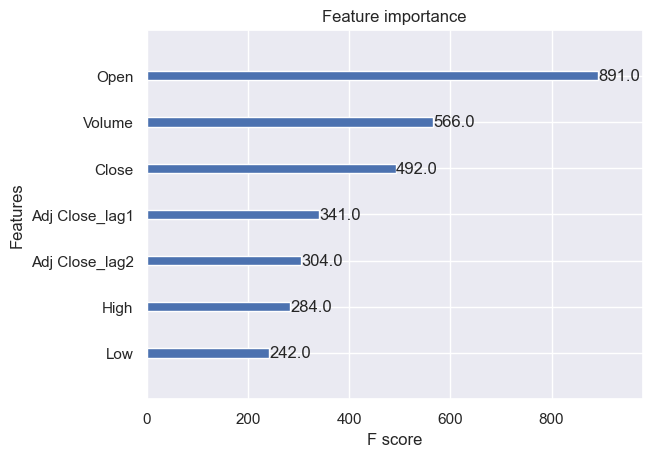

In [269]:
xgb.plot_importance(bst)
plt.show()

In [270]:
def generate_data(df, r=0.9):
    df["Adj Close_lag1"]=df["Adj Close"].shift(1)
    df["Adj Close_lag2"]=df["Adj Close"].shift(2)
    split_i = int(len(df)*r)
    train=df[:split_i]
    test=df[split_i:]
    X_train=train.drop("Adj Close", axis=1)
    y_train=train["Adj Close"]
    X_test=test.drop("Adj Close", axis=1)
    y_test=test["Adj Close"]
    print(y_test.shape)
    return X_train, y_train, X_test, y_test

In [271]:
# Train for 12 stocks in Portfolio
predictions = {}
true = {}
assigned = False
indices = None
for stock in stocks:    
    df = yf.download(stock, start=start_date, end=end_date)
    X_train, y_train, X_test, y_test = generate_data(df)
    # Sample dataset and training process
    dtrain = xgb.DMatrix(X_train, label=y_train)
    params = {
        'objective': 'reg:squarederror', 
        'eval_metric': 'rmse'
    }
    num_rounds = 100
    bst = xgb.train(params, dtrain, num_rounds)
    predictions[stock] = bst.predict(xgb.DMatrix(X_test))
    true[stock] = y_test
    if not assigned:
        indices = y_test.index
        assigned = True
    joblib.dump(bst, f"models/{stock}.joblib")
    

[*********************100%%**********************]  1 of 1 completed
(101,)
[*********************100%%**********************]  1 of 1 completed
(101,)
[*********************100%%**********************]  1 of 1 completed
(101,)
[*********************100%%**********************]  1 of 1 completed
(101,)
[*********************100%%**********************]  1 of 1 completed
(101,)
[*********************100%%**********************]  1 of 1 completed
(101,)
[*********************100%%**********************]  1 of 1 completed
(101,)
[*********************100%%**********************]  1 of 1 completed
(101,)
[*********************100%%**********************]  1 of 1 completed
(101,)
[*********************100%%**********************]  1 of 1 completed
(101,)
[*********************100%%**********************]  1 of 1 completed
(101,)
[*********************100%%**********************]  1 of 1 completed
(101,)
[*********************100%%**********************]  1 of 1 completed
(101,)
[***********

In [272]:
pred_df = pd.DataFrame({key: pd.Series(value) for key, value in predictions.items()})
true_df = pd.DataFrame({key: pd.Series(value) for key, value in true.items()})
pred_df.index=indices
true_df.index=indices
pred_df.shape

(101, 24)

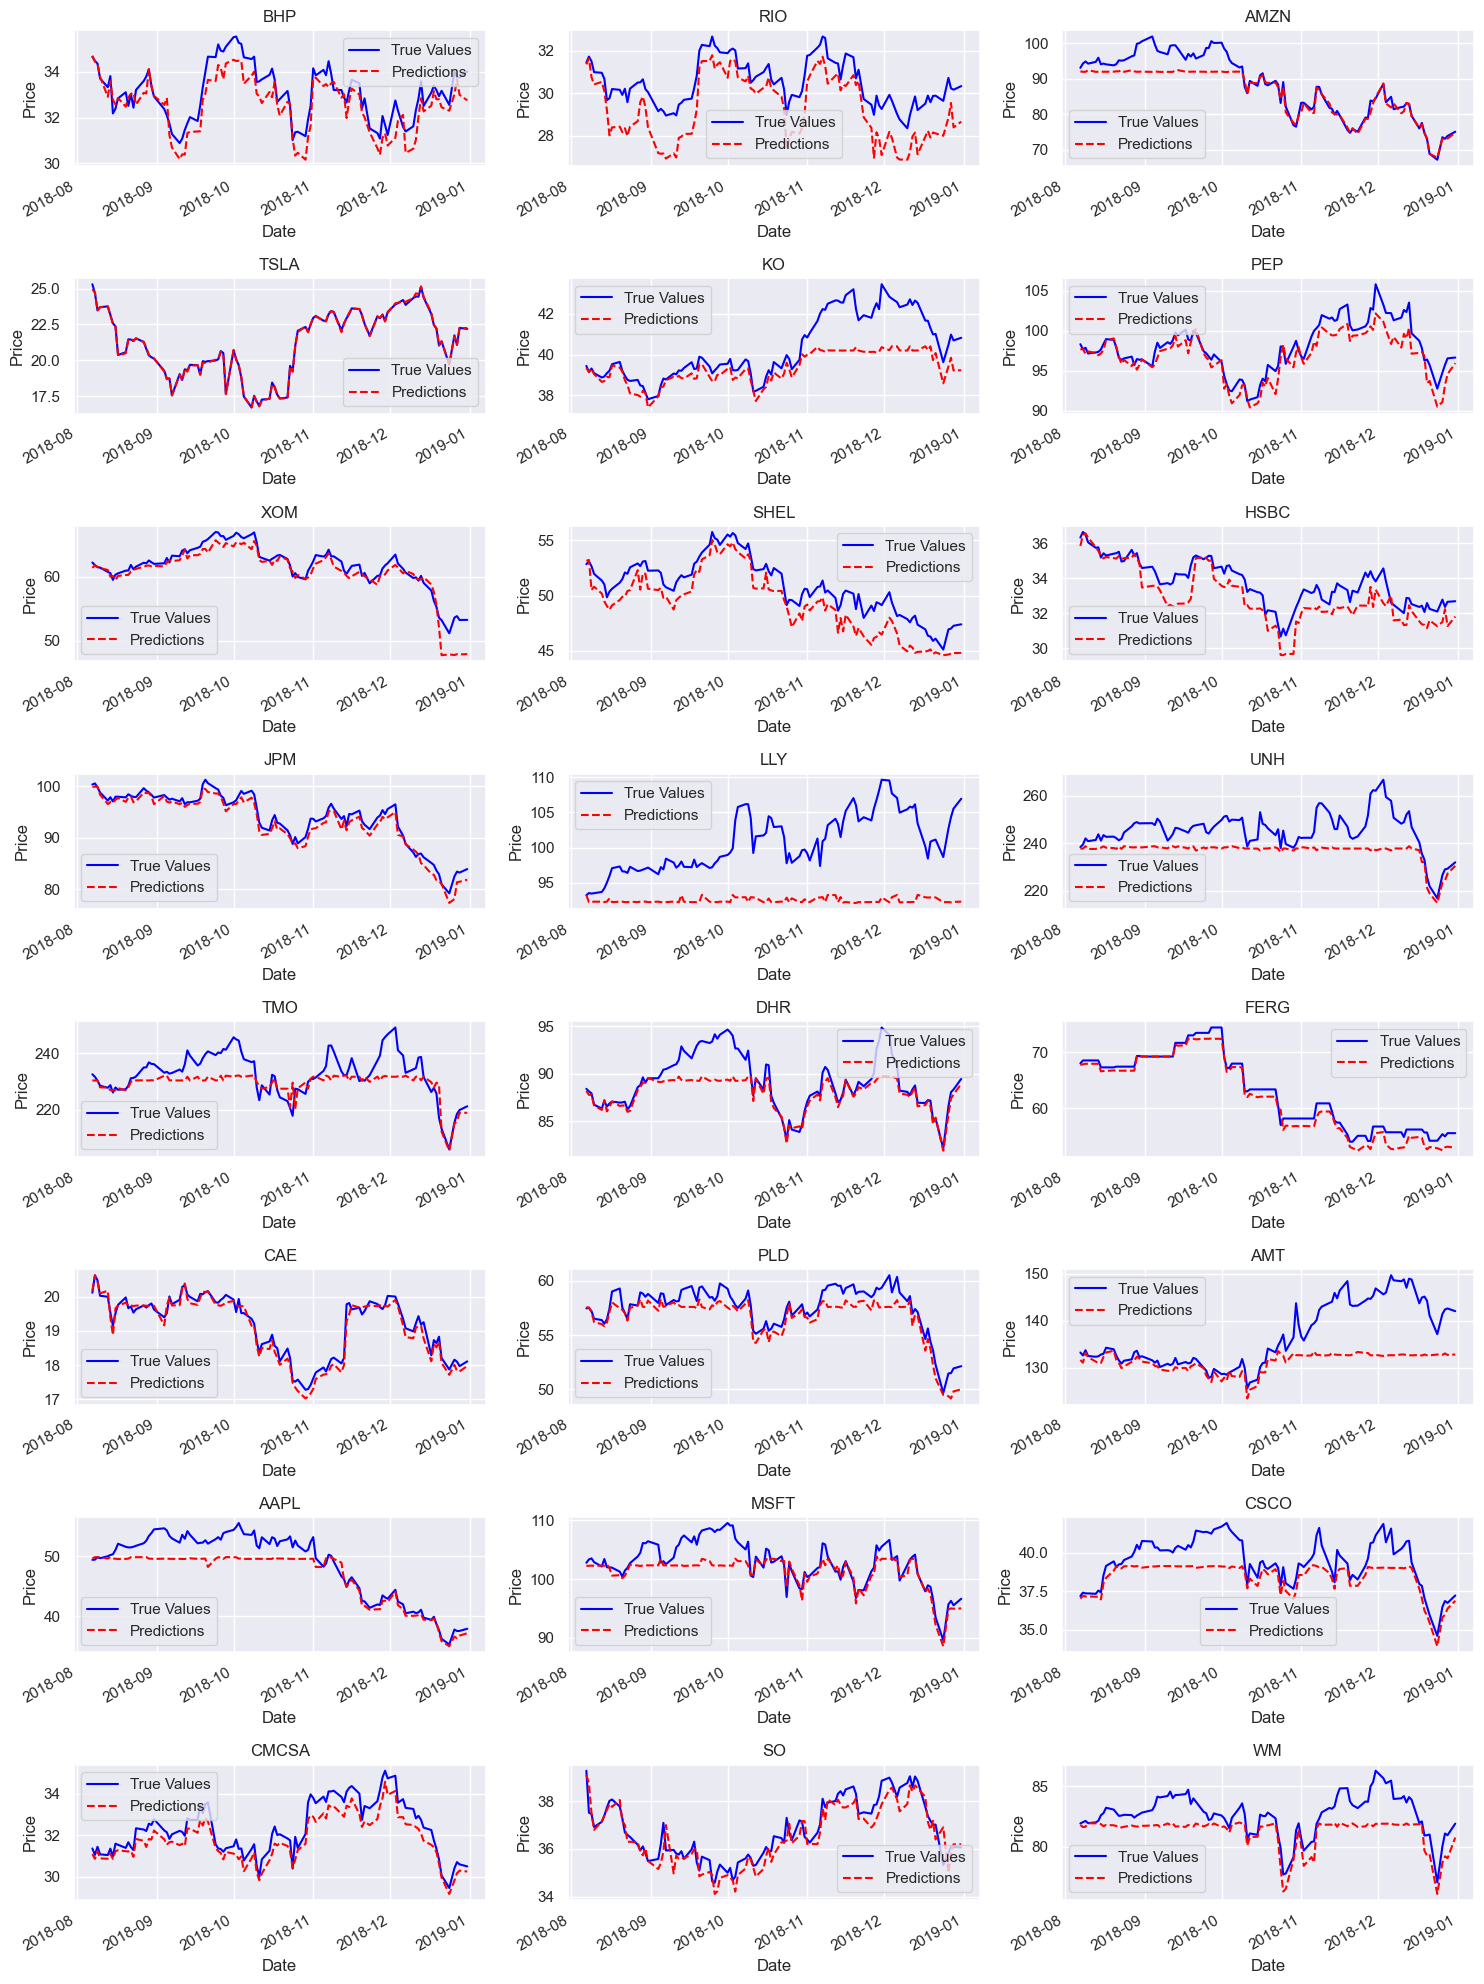

In [276]:
fig, axes = plt.subplots(8, 3, figsize=(15, 4 * 5))
for idx, stock in enumerate(pred_df.columns):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    true_df[stock].plot(ax=ax, label="True Values", color="blue")
    pred_df[stock].plot(ax=ax, label="Predictions", linestyle="--", color="red")
    
    ax.set_title(stock)
    ax.set_ylabel("Price")
    ax.legend()

plt.tight_layout()
plt.show()